# AI stock analysis

[![Open in Google Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/PauliusU/AI-stock-analysis/blob/master/AI-stock-analysis.ipynb)

## Summary, goals and methodology



Project uses combinations of models based on neural networks (`LSTM` and `GRU`) and a linear model (`ARIMA`). This is due to a fact that time series data often contain both linear and nonlinear patterns. Therefore, neither ARIMA nor neural networks can be adequate in modeling and predicting time series data. The ARIMA model cannot deal with nonlinear relationships while the neural network model alone is not able to handle both linear and nonlinear patterns equally well.

All models are trained with the same data set - price of Tesla shares for the last 5 years:
1. First approach is price prediction using `ARIMA` (Auto Regressive Integrated Moving Average) model. ❗ N.B. ARIMA was not used during our AI course ❗
2. Another approach uses `LSTM` (Long Short-Term memory) neural network — probably the most popular machine learning approach for stock market prediction.
3. Final approach utilizes `GRU` (Gated Recurrent Unit) network.

Final comparison of each approach is measured by the `RMSE` (root-mean-square error). The lower the error, the better the model is.

The comparison result shows that in our experiments the GRU method was the most accurate, followed by the LSTM method in the second place and ARIMA in the third.

## Getting the data

This section uses Yahoo Finance API to fetch share price data for the last 5 years and visualizes result in the plot.

In [ ]:
# Use Yahoo Finance's API wrapper
!pip install yfinance
import yfinance as yf

print(f"yfinance version: {yf.__version__}")

yfinance version: 0.1.85


In [ ]:
# Get stock data for the last 5 years

ticker = 'TSLA'
stock_data = yf.download(ticker, start='2017-11-01', end='2022-11-01')
print(stock_data.head())
print(stock_data.tail())

# Variables used later in models
close_prices = stock_data['Close']
values = close_prices.values

[*********************100%***********************]  1 of 1 completed
                 Open       High        Low      Close  Adj Close     Volume
Date                                                                        
2017-11-01  22.150000  22.174000  21.350668  21.405333  21.405333  126859500
2017-11-02  20.008667  20.579332  19.508667  19.950666  19.950666  296871000
2017-11-03  19.966667  20.416668  19.675333  20.406000  20.406000  133410000
2017-11-06  20.466667  20.500000  19.934000  20.185333  20.185333   97290000
2017-11-07  20.068001  20.433332  20.002001  20.403334  20.403334   79414500
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2022-10-25  210.100006  224.350006  210.000000  222.419998  222.419998   
2022-10-26  219.399994  230.600006  218.199997  224.639999  224.639999   
2022-10-27  229.770004  233.809998  222.850006  225.089996  225.089996   
2022-10-28  225.399994

Text(0, 0.5, 'Closing price in USD')

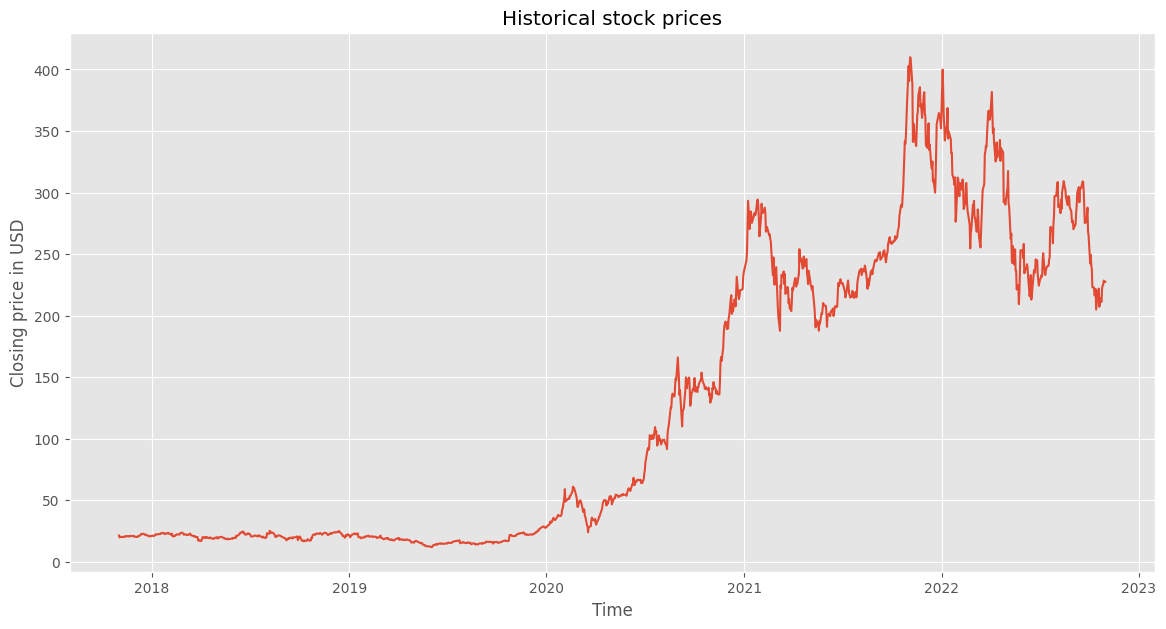

In [ ]:
# Plot closing price over time

import matplotlib.pyplot as plt

plt.style.use('ggplot')
plt.figure(figsize=(14, 7))
plt.title('Historical stock prices')
plt.plot(close_prices)
plt.xlabel('Time')
plt.ylabel('Closing price in USD')

## Model#1 ARIMA

Let's start by fitting a simple ARIMA model to forecast the next value of the stock price.

ARIMA, short for ‘Auto Regressive Integrated Moving Average’ is actually a class of models that "explains" a given time series based on its own past values, that is, its own lags and the lagged forecast errors, so that equation can be used to forecast future values. Any ‘non-seasonal’ time series that exhibits patterns and is not a random white noise can be modeled with ARIMA models.

Here we use a grid search procedure to test several configurations of hyperparameters for the ARIMA model. Finally, only the best configuration (with smallest RMSE) is used for comparison with LSTM and GRU.

In [ ]:
# Grid search ARIMA parameters for time series
from statsmodels.tsa.arima.model import ARIMA
import warnings
from math import sqrt
from sklearn.metrics import mean_squared_error


# Evaluate an ARIMA model for a given order (p,d,q)
# An ARIMA model is characterized by 3 terms: p, d, q where:
#       p is the order of the AR term
#       q is the order of the MA term
#       d is the number of differencing required to make the time series stationary
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.8)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse, predictions, history


# Evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg, best_predictions, best_history, = float(
        "inf"), None, list(), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p, d, q)
                try:
                    rmse, predictions, history = evaluate_arima_model(dataset,
                                                                      order)
                    if rmse < best_score:
                        best_score, best_cfg, best_predictions, best_history = rmse, order, predictions, history
                    print(f"ARIMA{order} RMSE={rmse:.3f}")
                except:
                    continue
    print(f"Best ARIMA{best_cfg} RMSE={best_score:.3f}")
    return best_score, best_predictions, best_history


# Evaluate parameters. Increasing ranges takes more time, but can result in more accurate model. For example, p_values = [0, 1, 2, 4, 6, 8, 10]
p_values = [0]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
rmse_arima, predictions_arima, history_arima = evaluate_models(values, p_values,
                                                               d_values,
                                                               q_values)

ARIMA(0, 0, 0) RMSE=193.593
ARIMA(0, 0, 1) RMSE=100.300
ARIMA(0, 0, 2) RMSE=68.382
ARIMA(0, 1, 0) RMSE=12.268
ARIMA(0, 1, 1) RMSE=12.281
ARIMA(0, 1, 2) RMSE=12.313
ARIMA(0, 2, 0) RMSE=17.760
ARIMA(0, 2, 1) RMSE=12.339
ARIMA(0, 2, 2) RMSE=12.383
Best ARIMA(0, 1, 0) RMSE=12.268


## Prepare training and test sets for RNNs (LSTM and GRU)

To prepare data to train and test models, only the closing price would be needed. Cell below gets 80% of these data points for closing price, normalizes them, and converts them into 2D array.

As we use LSTM and GRU neural networks we also need to scale the data in the column ‘Close’ because the machine learning algorithm works much better with scaled than with regular data. Closing price is scaled in the range between 0 and 1. This is just the preliminary operation which we need to execute to let our models work with better efficiency.

In [ ]:
# Prepare training set

import numpy as np
from sklearn.preprocessing import MinMaxScaler

training_data_len = int(len(values) * 0.8)

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(values.reshape(-1, 1))
train_data = scaled_data[0: training_data_len, :]

x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i - 60:i, 0])
    y_train.append(train_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))


In [ ]:
# Prepare test set

test_data = scaled_data[training_data_len - 60:, :]
x_test = []
y_test = values[training_data_len:]

for i in range(60, len(test_data)):
    x_test.append(test_data[i - 60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

## Model#2 LSTM

In [ ]:
# Check if GPU is used

import tensorflow as tf

print(
    f"Number of GPUs Available: {len(tf.config.list_physical_devices('GPU'))}")

# Print the list of available training devices - alternative method to verify TensorFlow sees the GPU
print(tf.config.list_physical_devices())

Number of GPUs Available: 0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [ ]:
# Set up LSTM network architecture

from tensorflow import keras

model_lstm = keras.Sequential()
# 100 neurons on the first layer of LSTM
model_lstm.add(
    keras.layers.LSTM(100, return_sequences=True,
                      input_shape=(x_train.shape[1], 1)))
# 100 neurons on the second layer of LSTM
model_lstm.add(keras.layers.LSTM(100, return_sequences=False))
# Dense with 25 neurons
model_lstm.add(keras.layers.Dense(25))
# Just one neuron which is our result on the last step of the model
model_lstm.add(keras.layers.Dense(1))
model_lstm.summary()

# Set optimizer and loss function
# Use optimizer ‘adam’ which is the most popular in tasks of stock price prediction
model_lstm.compile(optimizer='adam', loss='mean_squared_error')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 100)           40800     
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 25)                2525      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 123,751
Trainable params: 123,751
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Train the LSTM model

# Teach model during 80 epochs (computations) with batch size on each epoch equal to 10 (1/10 of samples)
EPOCHS = 80
BATCH_SIZE = 10

# Show progress bar with verbose=1
history_lstm = model_lstm.fit(x_train, y_train, batch_size=BATCH_SIZE,
                              epochs=EPOCHS,
                              verbose=1)

Epoch 1/80
95/95 [==============================] - 7s 42ms/step - loss: 0.0028
Epoch 2/80
95/95 [==============================] - 4s 44ms/step - loss: 7.3303e-04
Epoch 3/80
95/95 [==============================] - 4s 44ms/step - loss: 6.2277e-04
Epoch 4/80
95/95 [==============================] - 5s 52ms/step - loss: 4.9825e-04
Epoch 5/80
95/95 [==============================] - 5s 49ms/step - loss: 5.9795e-04
Epoch 6/80
95/95 [==============================] - 4s 42ms/step - loss: 4.7670e-04
Epoch 7/80
95/95 [==============================] - 4s 43ms/step - loss: 4.3951e-04
Epoch 8/80
95/95 [==============================] - 4s 44ms/step - loss: 5.6243e-04
Epoch 9/80
95/95 [==============================] - 4s 44ms/step - loss: 4.0642e-04
Epoch 10/80
95/95 [==============================] - 4s 42ms/step - loss: 3.6312e-04
Epoch 11/80
95/95 [==============================] - 4s 42ms/step - loss: 2.9131e-04
Epoch 12/80
95/95 [==============================] - 4s 43ms/step - loss: 3.28

In [ ]:
# Evaluation of LSTM

predictions_lstm = model_lstm.predict(x_test)
predictions_lstm = scaler.inverse_transform(predictions_lstm)
rmse_lstm = np.sqrt(np.mean(predictions_lstm - y_test) ** 2)
print(rmse_lstm)

8/8 [==============================] - 1s 24ms/step
5.167312379867312


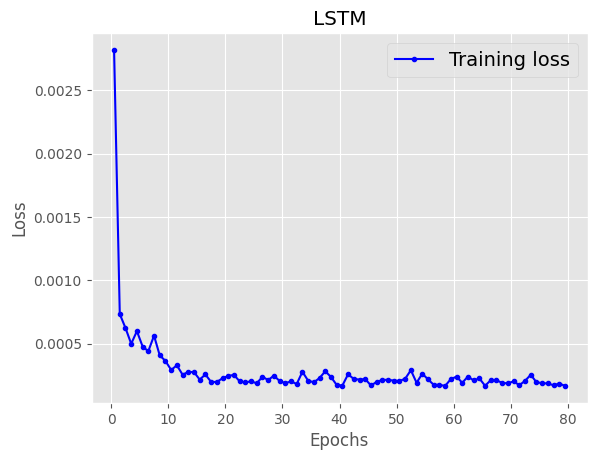

In [ ]:
import matplotlib as mpl

def plot_learning_curves(loss, title):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.title(title)
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)


plot_learning_curves(history_lstm.history["loss"], 'LSTM')

## Model#3 GRU

In [ ]:
# Set up GRU network architecture

model_gru = keras.Sequential()
model_gru.add(keras.layers.GRU(units=50, return_sequences=True,
                               input_shape=(x_train.shape[1], 1)))
model_gru.add(keras.layers.GRU(units=50))
model_gru.add(keras.layers.Dense(1))

# Use the same optimizer and loss function as with LSTM
# Use optimizer ‘adam’ which is the most popular in tasks of stock price prediction
model_gru.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
# Train the GRU model

# Use the same EPOCHS and BATCH_SIZE params as in LSTM model. Show progress bar with verbose=1,
history_gru = model_gru.fit(x_train, y_train, batch_size=BATCH_SIZE,
                            epochs=EPOCHS, verbose=1)

Epoch 1/80
95/95 [==============================] - 4s 39ms/step - loss: 1.8583e-04
Epoch 2/80
95/95 [==============================] - 4s 39ms/step - loss: 1.6747e-04
Epoch 3/80
95/95 [==============================] - 4s 39ms/step - loss: 1.7266e-04
Epoch 4/80
95/95 [==============================] - 4s 38ms/step - loss: 1.6786e-04
Epoch 5/80
95/95 [==============================] - 4s 38ms/step - loss: 1.8400e-04
Epoch 6/80
95/95 [==============================] - 4s 37ms/step - loss: 1.5877e-04
Epoch 7/80
95/95 [==============================] - 4s 39ms/step - loss: 1.7079e-04
Epoch 8/80
95/95 [==============================] - 4s 40ms/step - loss: 1.6397e-04
Epoch 9/80
95/95 [==============================] - 4s 40ms/step - loss: 1.8358e-04
Epoch 10/80
95/95 [==============================] - 4s 39ms/step - loss: 1.7503e-04
Epoch 11/80
95/95 [==============================] - 4s 38ms/step - loss: 1.5843e-04
Epoch 12/80
95/95 [==============================] - 4s 38ms/step - loss: 

In [ ]:
# Evaluation of GRU model

predictions_gru = model_gru.predict(x_test)
predictions_gru = scaler.inverse_transform(predictions_gru)
rmse_gru = np.sqrt(np.mean(predictions_gru - y_test) ** 2)
print(rmse_gru)

8/8 [==============================] - 0s 11ms/step
3.328597356402685


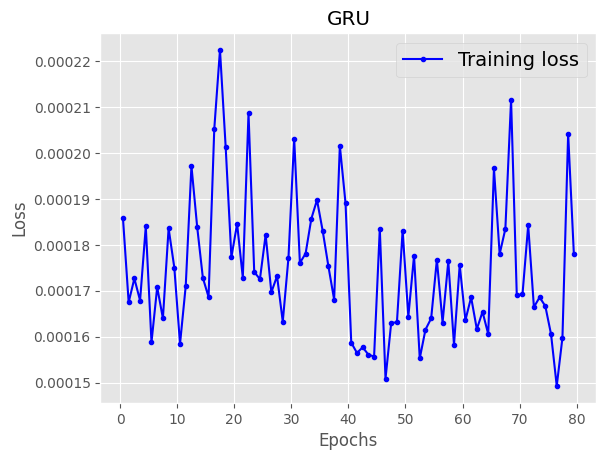

In [ ]:
plot_learning_curves(history_gru.history["loss"], 'GRU')

## Final results and conclusions

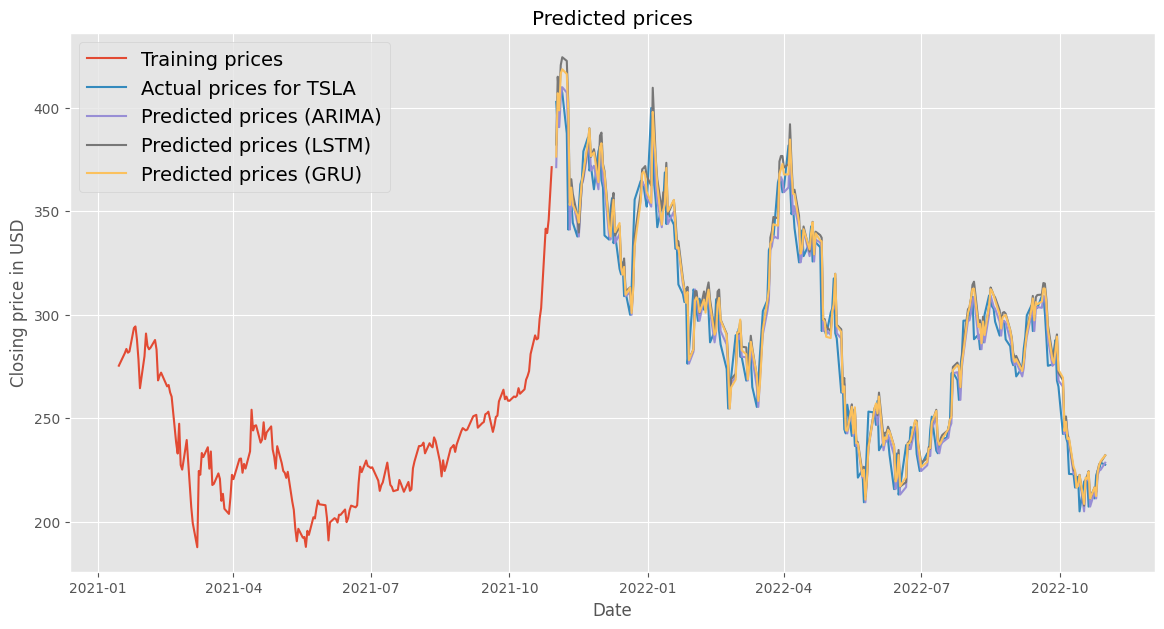

In [ ]:
# Visualize prices predicted by all models: ARIMA, LSTM and GRU

data = stock_data.filter(['Close'])
train = data[:training_data_len]
validation = data[training_data_len:]
validation['Predictions_ARIMA'] = predictions_arima
validation['Predictions_LSTM'] = predictions_lstm
validation['Predictions_GRU'] = predictions_gru
plt.style.use('ggplot')
plt.figure(figsize=(14, 7))
plt.title('Predicted prices')
plt.xlabel('Date')
plt.ylabel('Closing price in USD')
plt.plot(train[-200:])  # Plot last 200 entries
plt.plot(validation[[
    'Close',
    'Predictions_ARIMA',
    'Predictions_LSTM',
    'Predictions_GRU'
]])
plt.legend([
    'Training prices',
    f'Actual prices for {ticker}',
    'Predicted prices (ARIMA)',
    'Predicted prices (LSTM)',
    'Predicted prices (GRU)'
],
    loc='upper left',
    fontsize=14)
plt.show()

During our experiments performance of each model was based on the RMSE. After comparing the result, models were ranked in the following order from the most to the least accurate:
1. `GRU` model constantly showed the best results with the RMSE of around `3.328`.
2. `LSTM` had RMSE around `5.167`.
3. Finally, `ARIMA` architecture proved to be the least accurate with RMSE of around `12.268`.

Admittedly, each model could be further improved with fine-tuning. However, results of the practical projects confirms that **generally** with the large quantity of data deep learning-based algorithms, such as LSTM or GRU, outperform traditional algorithms, such as the ARIMA model. As a result of the literature review, it is noted that the ARIMA model produced better results with a smaller quantity of data in previous academic studies. Reference: [Elsaraiti, M.; Merabet, A. A Comparative Analysis of the ARIMA and LSTM Predictive Models and their Effectiveness for Predicting Wind Speed. Energies 2021, 14, 6782.](https://doi.org/10.3390/en14206782).

GRU model had the nice added bonus that it was the fastest to train (even without GPU-acceleration). It could be explained by the fact that GRUs have simpler internal structure. I.e. LSTMs have 3 gates, GRUs have only 2 gates.

It is worth mentioning that it is easier to utilize GPU-acceleration when training models based on RNNs (LSTM and GRU). For example, Google Colab environment by default trained RNN based models using GPU-acceleration. On the other hand, GPU-accelerated ARIMA implementations are also available (for instance: [RAPIDS cuML](https://github.com/rapidsai/cuml)) but are more difficult to implement in practice.
